In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
vineethakkinapalli_ucf50_action_recognition_dataset_path = kagglehub.dataset_download('vineethakkinapalli/ucf50-action-recognition-dataset')

print('Data source import complete.')


In [ ]:
# %% [markdown]
# # A. SIMPLE 3D CNN MODEL FROM TENSORFLOW.KERAS (TF 2.x)

# %%
import os, gc, json, math, glob, random, time
import numpy as np
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import (Input, Conv3D, MaxPooling3D, Dense, Flatten, Dropout, LeakyReLU, Add, BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score

print("TensorFlow:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print("GPUs:", gpus)
try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass


2025-10-03 13:31:30.764265: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759498291.001150      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759498291.065629      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow: 2.18.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# %%
class CFG:
    # === ĐƯỜNG DẪN ===
    DATA_ROOT = r"/kaggle/input/ucf50-action-recognition-dataset/UCF50"
    OUTPUT_DIR = "/kaggle/working/"
    SEED = 1337

    # === LẤY KHUNG HÌNH ===
    # Chế độ đơn giản: lấy đều 'NUM_FRAMES' khung theo chiều dài video
    NUM_FRAMES = 16
    IMG_SIZE = 112
    CENTER_CROP = False  # True nếu muốn crop giữa trước khi resize

    # === TRAIN ===
    VAL_RATIO = 0.2
    BATCH_SIZE = 4
    EPOCHS = 10
    LR = 1e-4
    DROPOUT = 0.2
    LABEL_SMOOTHING = 0.0
    USE_BATCHNORM = True

    # === AUGMENT ===
    HFLIP_PROB = 0.5
    BRIGHTNESS_DELTA = 20  # 0..255

# Seed + thư mục
random.seed(CFG.SEED); np.random.seed(CFG.SEED); tf.random.set_seed(CFG.SEED)
os.makedirs(CFG.OUTPUT_DIR, exist_ok=True)


In [ ]:
# %%
def _center_crop(img):
    h, w = img.shape[:2]
    side = min(h, w)
    y0 = (h - side) // 2
    x0 = (w - side) // 2
    return img[y0:y0+side, x0:x0+side]

def read_video_frames_uniform(path, num_frames=16, img_size=112, center_crop=False):
    """
    Đọc video và lấy đều 'num_frames' khung (linspace). Trả về (T,H,W,3) uint8 (0..255).
    """
    cap = cv2.VideoCapture(path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 0
    if total <= 0:
        cap.release()
        return None

    idxs = np.linspace(0, total - 1, num=num_frames, dtype=int)
    frames = []
    cur_idx = 0
    for i in range(total):
        ret, frame = cap.read()
        if not ret:
            break
        if i == idxs[cur_idx]:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if center_crop:
                frame = _center_crop(frame)
            frame = cv2.resize(frame, (img_size, img_size), interpolation=cv2.INTER_AREA)
            frames.append(frame)
            cur_idx += 1
            if cur_idx >= len(idxs):
                break
    cap.release()

    if len(frames) < num_frames:
        if len(frames) == 0:
            return None
        last = frames[-1]
        while len(frames) < num_frames:
            frames.append(last.copy())

    return np.stack(frames, axis=0)  # (T,H,W,3)


def random_horizontal_flip(video, p=0.5):
    if random.random() < p:
        return np.flip(video, axis=2).copy()  # flip theo trục W
    return video

def random_brightness(video, delta=20):
    if delta <= 0: return video
    shift = random.randint(-delta, delta)
    v = np.clip(video.astype(np.int32) + shift, 0, 255).astype(np.uint8)
    return v


In [ ]:
# %%
def scan_dataset(root):
    print(f"Scanning dataset root: {root}")
    print(f"Root path exists: {os.path.exists(root)}")

    if not os.path.exists(root):
        print("ERROR: Dataset root path does not exist!")
        return [], []

    try:
        all_items = os.listdir(root)
        print(f"Total items in root: {len(all_items)}")

        classes = sorted([d for d in all_items if os.path.isdir(os.path.join(root, d))])
        print(f"Found {len(classes)} class directories")
        if classes:
            print(f"First 5 classes: {classes[:5]}")

        class_to_idx = {c:i for i,c in enumerate(classes)}
        samples = []

        for c in classes:
            vids = []
            class_path = os.path.join(root, c)

            for ext in ("*.avi","*.mp4","*.mkv","*.mov"):
                pattern = os.path.join(class_path, ext)
                found_files = glob.glob(pattern)
                vids.extend(found_files)  # This line was missing .extend()

            print(f"Class '{c}': found {len(vids)} videos")

            for v in vids:
                samples.append({"path": v, "label": class_to_idx[c], "cls": c})

        print(f"Total videos found: {len(samples)}")
        return samples, classes

    except Exception as e:
        print(f"ERROR scanning dataset: {e}")
        return [], []

samples, classes = scan_dataset(CFG.DATA_ROOT)
num_classes = len(classes)
print(f"Tổng video: {len(samples)} | Số lớp: {num_classes}")

if len(samples) == 0:
    print("ERROR: No video samples found! Please check:")
    print("1. Dataset path is correct")
    print("2. Video files exist in class directories")
    print("3. Video files have supported extensions (.avi, .mp4, .mkv, .mov)")
    raise ValueError("Cannot proceed with zero samples. Please fix dataset path or check video files.")

print("Một vài lớp:", classes[:10])

# Only proceed with train/test split if we have samples
train_idx, val_idx = train_test_split(
    np.arange(len(samples)),
    test_size=CFG.VAL_RATIO,
    random_state=CFG.SEED,
    stratify=[s["label"] for s in samples]
)

train_samples = [samples[i] for i in train_idx]
val_samples   = [samples[i] for i in val_idx]
print(f"Train: {len(train_samples)} | Val: {len(val_samples)}")


Scanning dataset root: /kaggle/input/ucf50-action-recognition-dataset/UCF50
Root path exists: True
Total items in root: 50
Found 50 class directories
First 5 classes: ['BaseballPitch', 'Basketball', 'BenchPress', 'Biking', 'Billiards']
Class 'BaseballPitch': found 150 videos
Class 'Basketball': found 137 videos
Class 'BenchPress': found 160 videos
Class 'Biking': found 145 videos
Class 'Billiards': found 150 videos
Class 'BreastStroke': found 101 videos
Class 'CleanAndJerk': found 112 videos
Class 'Diving': found 153 videos
Class 'Drumming': found 161 videos
Class 'Fencing': found 111 videos
Class 'GolfSwing': found 142 videos
Class 'HighJump': found 123 videos
Class 'HorseRace': found 127 videos
Class 'HorseRiding': found 197 videos
Class 'HulaHoop': found 125 videos
Class 'JavelinThrow': found 117 videos
Class 'JugglingBalls': found 122 videos
Class 'JumpRope': found 148 videos
Class 'JumpingJack': found 123 videos
Class 'Kayaking': found 157 videos
Class 'Lunges': found 141 videos
C

In [ ]:
# %%
def load_and_preprocess(item, training=True):
    path = item["path"]; label = item["label"]

    vid = read_video_frames_uniform(
        path,
        num_frames=CFG.NUM_FRAMES,
        img_size=CFG.IMG_SIZE,
        center_crop=CFG.CENTER_CROP
    )
    if vid is None:
        vid = np.zeros((CFG.NUM_FRAMES, CFG.IMG_SIZE, CFG.IMG_SIZE, 3), dtype=np.uint8)

    if training:
        vid = random_horizontal_flip(vid, CFG.HFLIP_PROB)
        vid = random_brightness(vid, CFG.BRIGHTNESS_DELTA)

    vid = vid.astype(np.float32) / 255.0  # [0,1]
    y = tf.keras.utils.to_categorical(label, num_classes)
    return vid, y

def make_dataset(sample_list, batch_size, training=True):
    def gen():
        for it in sample_list:
            yield load_and_preprocess(it, training=training)
    out_sig = (
        tf.TensorSpec(shape=(CFG.NUM_FRAMES, CFG.IMG_SIZE, CFG.IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(num_classes,), dtype=tf.float32)
    )
    ds = tf.data.Dataset.from_generator(gen, output_signature=out_sig)
    if training:
        ds = ds.shuffle(512, seed=CFG.SEED, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_samples, CFG.BATCH_SIZE, training=True)
val_ds   = make_dataset(val_samples, CFG.BATCH_SIZE, training=False)

for xb, yb in train_ds.take(1):
    print("Batch X:", xb.shape, "Batch y:", yb.shape)  # (B,T,H,W,3), (B,C)


I0000 00:00:1759498305.926231      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Batch X: (4, 16, 112, 112, 3) Batch y: (4, 50)


In [ ]:
# %%
def build_parallel_3dcnn(input_shape, num_classes, dropout=0.2, use_batchnorm=True,
                         kernel_small=(3,3,3), kernel_1x1=(1,1,1)):

    inp = Input(shape=input_shape)

    x = Conv3D(16, kernel_size=kernel_small, padding='same', use_bias=not use_batchnorm)(inp)
    if use_batchnorm: x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.001)(x)

    x = Conv3D(32, kernel_size=kernel_small, padding='same', use_bias=not use_batchnorm)(x)
    if use_batchnorm: x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.001)(x)

    # Parallel branch 1
    p1 = Conv3D(16, kernel_size=kernel_1x1, padding='same', use_bias=not use_batchnorm)(x)
    if use_batchnorm: p1 = BatchNormalization()(p1)
    p1 = LeakyReLU(alpha=0.001)(p1)
    p1 = MaxPooling3D(pool_size=(2,2,2), padding='same')(p1)

    p1 = Conv3D(16, kernel_size=kernel_1x1, padding='same', use_bias=not use_batchnorm)(p1)
    if use_batchnorm: p1 = BatchNormalization()(p1)
    p1 = LeakyReLU(alpha=0.001)(p1)
    p1 = MaxPooling3D(pool_size=(2,2,2), padding='same')(p1)

    # Parallel branch 2
    p2 = Conv3D(8, kernel_size=kernel_1x1, padding='same', use_bias=not use_batchnorm)(x)
    if use_batchnorm: p2 = BatchNormalization()(p2)
    p2 = LeakyReLU(alpha=0.001)(p2)
    p2 = MaxPooling3D(pool_size=(2,2,2), padding='same')(p2)

    p2 = Conv3D(16, kernel_size=kernel_1x1, padding='same', use_bias=not use_batchnorm)(p2)
    if use_batchnorm: p2 = BatchNormalization()(p2)
    p2 = LeakyReLU(alpha=0.001)(p2)
    p2 = MaxPooling3D(pool_size=(2,2,2), padding='same')(p2)

    # Parallel branch 3
    p3 = Conv3D(4, kernel_size=kernel_1x1, padding='same', use_bias=not use_batchnorm)(x)
    if use_batchnorm: p3 = BatchNormalization()(p3)
    p3 = LeakyReLU(alpha=0.001)(p3)
    p3 = MaxPooling3D(pool_size=(2,2,2), padding='same')(p3)

    p3 = Conv3D(16, kernel_size=kernel_1x1, padding='same', use_bias=not use_batchnorm)(p3)
    if use_batchnorm: p3 = BatchNormalization()(p3)
    p3 = LeakyReLU(alpha=0.001)(p3)
    p3 = MaxPooling3D(pool_size=(2,2,2), padding='same')(p3)

    out = Add()([p1, p2, p3])
    out = MaxPooling3D(pool_size=(2,2,2), padding='same')(out)
    out = Flatten()(out)
    if dropout > 0:
        out = Dropout(dropout)(out)
    out = Dense(256, activation='relu')(out)
    out = Dense(num_classes, activation='softmax')(out)

    model = Model(inp, out, name="Parallel3DCNN_3x3x3")
    return model

input_shape = (CFG.NUM_FRAMES, CFG.IMG_SIZE, CFG.IMG_SIZE, 3)
model = build_parallel_3dcnn(
    input_shape=input_shape,
    num_classes=num_classes,
    dropout=CFG.DROPOUT,
    use_batchnorm=CFG.USE_BATCHNORM
)
model.compile(
    optimizer=Adam(learning_rate=CFG.LR),
    loss=CategoricalCrossentropy(label_smoothing=CFG.LABEL_SMOOTHING),
    metrics=['accuracy']
)
model.summary(line_length=120)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Parallel3DCNN_3x3x3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer (InputLayer)          │ (None, 16, 112, 112, 3)      │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv3d (Conv3D)                   │ (None, 16, 112, 112, 16)     │             1,296 │ input_layer[0][0]         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization               │ (None, 16, 112, 112, 16)     │                64 │ conv3d[0][0]              
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ leaky_re_lu (LeakyReLU)           │ (None, 16, 112, 112, 16)     │                 0 │ batch_normalization[0][0] 
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv3d_1 (Conv3D)                 │ (None, 16, 112, 112, 32)     │            13,824 │ leaky_re_lu[0][0]         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_1             │ (None, 16, 112, 112, 32)     │               128 │ conv3d_1[0][0]            
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ leaky_re_lu_1 (LeakyReLU)         │ (None, 16, 112, 112, 32)     │                 0 │ batch_normalization_1[0][0
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv3d_2 (Conv3D)                 │ (None, 16, 112, 112, 16)     │               512 │ leaky_re_lu_1[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv3d_4 (Conv3D)                 │ (None, 16, 112, 112, 8)      │               256 │ leaky_re_lu_1[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv3d_6 (Conv3D)                 │ (None, 16, 112, 112, 4)      │               128 │ leaky_re_lu_1[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_2             │ (None, 16, 112, 112, 16)     │                64 │ conv3d_2[0][0]            
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_4             │ (None, 16, 112, 112, 8)      │                32 │ conv3d_4[0][0]            
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_6             │ (None, 16, 112, 112, 4)      │                16 │ conv3d_6[0][0]            
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ leaky_re_lu_2 (LeakyReLU)         │ (None, 16, 112, 11

 Total params: 1,635,698 (6.24 MB)

 Trainable params: 1,635,450 (6.24 MB)

 Non-trainable params: 248 (992.00 B)

In [ ]:
# %%
ckpt_path = os.path.join(CFG.OUTPUT_DIR, f"{model.name}_best.keras")
callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy", mode="max", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=5, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.5, patience=2, verbose=1),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CFG.EPOCHS,
    callbacks=callbacks,
    verbose=1
)

with open(os.path.join(CFG.OUTPUT_DIR, f"{model.name}_history.json"), "w") as f:
    json.dump(history.history, f, indent=2)
print("Best ckpt:", ckpt_path)


Epoch 1/10


I0000 00:00:1759498361.902526      92 service.cc:148] XLA service 0x7f71b402ed00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759498361.903632      92 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759498362.622853      92 cuda_dnn.cc:529] Loaded cuDNN version 90300


      2/Unknown 36s 66ms/step - accuracy: 0.0000e+00 - loss: 15.0287

I0000 00:00:1759498370.127262      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   1336/Unknown 290s 190ms/step - accuracy: 0.0264 - loss: 4.9594

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.03291, saving model to /kaggle/working/Parallel3DCNN_3x3x3_best.keras
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 356s 240ms/step - accuracy: 0.0264 - loss: 4.9588 - val_accuracy: 0.0329 - val_loss: 3.9107 - learning_rate: 1.0000e-04
Epoch 2/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.0314 - loss: 3.9066
Epoch 2: val_accuracy improved from 0.03291 to 0.05610, saving model to /kaggle/working/Parallel3DCNN_3x3x3_best.keras
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 289s 201ms/step - accuracy: 0.0314 - loss: 3.9066 - val_accuracy: 0.0561 - val_loss: 3.8718 - learning_rate: 1.0000e-04
Epoch 3/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.0588 - loss: 3.8528
Epoch 3: val_accuracy improved from 0.05610 to 0.07554, saving model to /kaggle/working/Parallel3DCNN_3x3x3_best.keras
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 292s 203ms/step - accuracy: 0.0588 - loss: 3.8528 - val_accuracy: 0.0755 - val_loss: 3.7406 - learning_rate: 1.0000e-04
Epoch 4/10
1

In [ ]:
# Train tiếp thì acc sẽ tiếp tục tăng ạ. MMà e hết GPU Kaggle r ạ

In [ ]:
val_videos, val_labels = [], []
for it in val_samples:
    X, y = load_and_preprocess(it, training=False)
    val_videos.append(X); val_labels.append(np.argmax(y))
val_videos = np.stack(val_videos, axis=0)
val_labels = np.array(val_labels)

probs = model.predict(val_videos, batch_size=CFG.BATCH_SIZE, verbose=1)
preds = np.argmax(probs, axis=1)

acc = (preds == val_labels).mean()
bal_acc = balanced_accuracy_score(val_labels, preds)
print(f"[{model.name}] Val Accuracy: {acc:.4f} | Balanced Acc: {bal_acc:.4f}\n")

print("Classification Report:")
print(classification_report(val_labels, preds, target_names=classes, digits=4))

cm = confusion_matrix(val_labels, preds)
print("Confusion Matrix (top-left 10x10):")
size = min(10, cm.shape[0])
print(cm[:size,:size])


335/335 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step
[Parallel3DCNN_3x3x3] Val Accuracy: 0.1279 | Balanced Acc: 0.1211

Classification Report:
                    precision    recall  f1-score   support

     BaseballPitch     0.0000    0.0000    0.0000        30
        Basketball     0.0000    0.0000    0.0000        27
        BenchPress     0.1429    0.0625    0.0870        32
            Biking     0.0000    0.0000    0.0000        29
         Billiards     0.3919    0.9667    0.5577        30
      BreastStroke     0.2062    1.0000    0.3419        20
      CleanAndJerk     0.0000    0.0000    0.0000        22
            Diving     0.3333    0.5161    0.4051        31
          Drumming     0.0000    0.0000    0.0000        32
           Fencing     0.0000    0.0000    0.0000        22
         GolfSwing     0.0000    0.0000    0.0000        28
          HighJump     0.0000    0.0000    0.0000        25
         HorseRace     0.0000    0.0000    0.0000        25
       HorseRiding     0.03

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


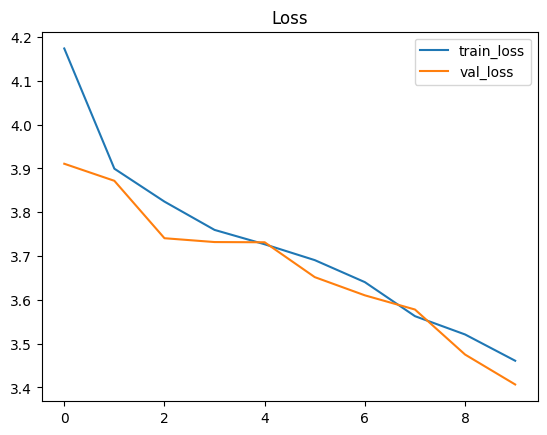

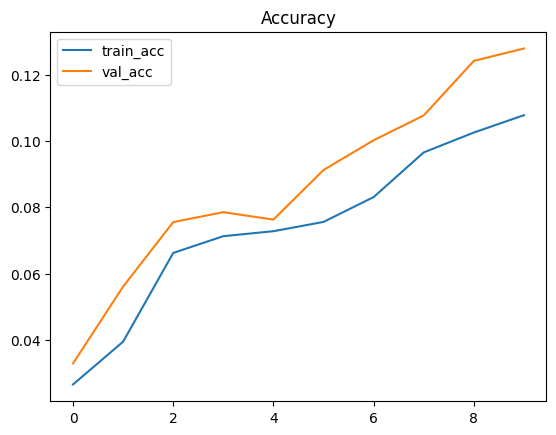

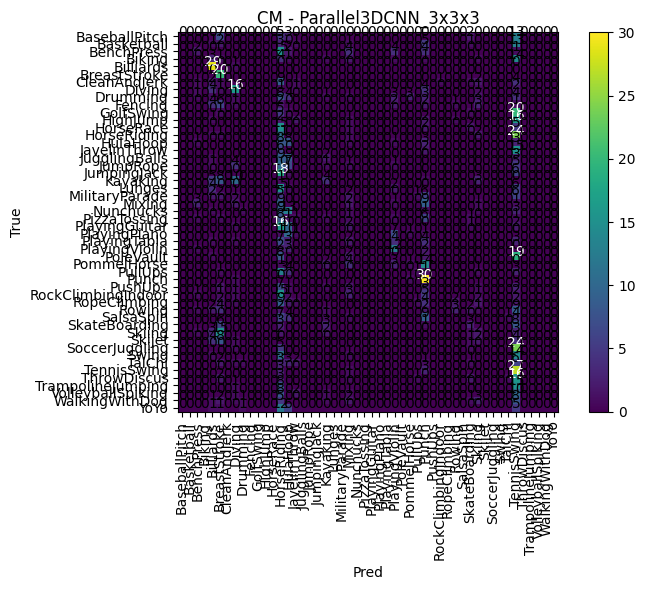

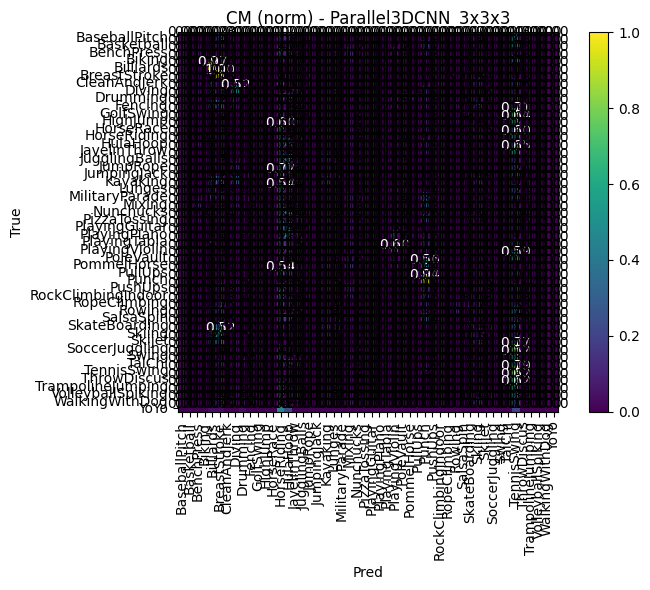

In [ ]:
# %%
import matplotlib.pyplot as plt
import itertools

def plot_history(his):
    plt.figure()
    plt.plot(his['loss'], label='train_loss')
    plt.plot(his['val_loss'], label='val_loss')
    plt.title('Loss'); plt.legend(); plt.show()

    plt.figure()
    plt.plot(his['accuracy'], label='train_acc')
    plt.plot(his['val_accuracy'], label='val_acc')
    plt.title('Accuracy'); plt.legend(); plt.show()

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title); plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True'); plt.xlabel('Pred'); plt.tight_layout()

plot_history(history.history)
plot_confusion_matrix(cm, classes, normalize=False, title=f'CM - {model.name}')
plot_confusion_matrix(cm, classes, normalize=True,  title=f'CM (norm) - {model.name}')
